## REI602M Machine Learning - Homework 6
### Due: *Sunday* 28.2.2021

**Objectives**: k-means clustering and recommender systems

**Name**: Alexander Guðmundsson, **email: ** (alg35@hi.is), **collaborators:** (if any)

Please provide your solutions by filling in the appropriate cells in this notebook, creating new cells as needed. Hand in your solution on Gradescope, taking care to locate the appropriate page numbers in the PDF document. Make sure that you are familiar with the course rules on collaboration (encouraged) and copying (very, very, bad).

### 1\. [Topic discovery via $k$-means, 30 points]

Here you are to use the $k$-means algorithm to cluster the Wikipedia data set from Homework 5 (file `wikipedia_corpus.npz`).

Run $k$-means with different values of $k$, e.g. $k=2,5,8$ and investigate your results by looking at the words and article titles associated with each centroid. Feel free to visit Wikipedia if an article’s content is unclear from its title. On the basis of your tests, select a final value of $k$ and run $k$-means again. Give a short description of the topics your clustering discovered along with the 5 most common words from each topic. If the topics do not make sense pick another value of $k$.

*Comments*:

1) When you run the $k$-means implementation in `sklearn.cluster.KMeans` it initializes the centroids by randomly assigning the data points to $k$ groups and taking the $k$ representatives as the means of the groups. (This means that if you run the function twice, with the same data, you might get diﬀerent results.) The cluster centers and labels can be accessed via the attributes `cluster_centers_` and `labels_`. The attribute `labels_` contains the index of each vector’s closest centroid (labels start from zero), so if the 30th entry in `labels` is 7, then the 30th vector’s closest centroid is the 7th entry in `centroids` (indexing starts from zero).

2) There are many ways to explore your results. For example, you could print the titles of selected articles in a cluster. Alternatively, you could ﬁnd a topic’s most common words by ordering `dictionary` by the size of its centroid’s entries. A larger entry for a word implies it was more common in articles from that topic.

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

data = np.load('./../homework05/wikipedia_corpus.npz', allow_pickle=True)
dictionary = data["dictionary"]
article_titles = data["article_titles"]
article_histograms = data["article_histograms"] #Data matrix

k = 32 #number of clusters
max_words = 5

kmeans = KMeans(n_clusters = k, init='random', random_state = 42)
kmeans.fit(article_histograms)
centers = kmeans.cluster_centers_
labels = kmeans.labels_

wordsInCluster = []
importanceIndex = []
#get the 5 top words for each cluster
for i in range(k):
    importance_sorted = np.argsort(centers[i])[:max_words]
    importanceIndex.append(importance_sorted)
    words = [dictionary[j] for j in importance_sorted]
    wordsInCluster.append(words)



#Let's find the titles belonging to each cluster, I will do this by
#creating a dictionary and placing each cluster with a label
titlesInCluster = {}
for i in range(len(labels)):
    if labels[i] in titlesInCluster:
        titlesInCluster[labels[i]].append(article_titles[i])
    else:
        titlesInCluster[labels[i]] = [article_titles[i]]
        
        
#finally, let's see if titles and words match with each cluster
for i in range(len(wordsInCluster)):
    
    #print titles in cluster i
    print("titles in cluster: " + str(i+1) + '\n')
    if i in titlesInCluster:
        for j in titlesInCluster[i]:
            print(str(j))
    else:
        print("No titles in cluster", str(i+1) + '\n')
    print('\n')
    
    
    #print top 5 words in cluster i
    print("Top 5 words in cluster" + str(i+1) +'\n')
    print(wordsInCluster[i])
    print('\n')
    
    
    


titles in cluster: 1

Convention on the Rights of Persons with Disabilities
International Seabed Authority
International Tribunal for the Law of the Sea
Joint United Nations Programme on HIV/AIDS
Office of the United Nations High Commissioner for Human Rights
Organisation for the Prohibition of Chemical Weapons
Outline of the United Nations
United Nations Convention on the Law of the Sea
United Nations Development Programme
United Nations Environment Programme
United Nations Human Settlements Programme
United Nations International Strategy for Disaster Reduction
United Nations Office for Project Services
United Nations Office on Drugs and Crime
United Nations Population Fund
United Nations System Staff College
United Nations University
United Nations Volunteers
UN Women
World Health Organization
World Intellectual Property Organization


Top 5 words in cluster1

['renoir', 'signal', 'signals', 'heat', 'temperature']


titles in cluster: 2

Guglielmo Marconi


Top 5 words in cluster2

[

### 2\. [Recommender systems, 70 points]

Here you will build a recommendation system for movie ratings, using data from the MovieLens web site. We start with a ''small'' data set with approx. 90,000 ratings of 3650 movies from 610 users and then move on to a larger set with
one million ratings from 6000 users on 4000 movies.

Each user typically only rates a few movies but we want to be able to predict ratings for all the movies the user hasn't rated. We do this by basing predictions for the unseen movies on ratings from all the other users using a method based on matrix factorization. We construct a rank-$k$  $n \times m$ user-movies matrix $R$ of movie ratings where $r_{ui}$ corresponds to the rating that user $u$ would give movie $i$. The prediction $\hat{r}_{ui}$ is given by
$$
\hat{r}_{ui} = w_u^T h_i
$$
where $w_1^T,\ldots,w^T_n$ are row vectors with $k$ elements and $h_1,\ldots,h_m$ are column vectors with $k$ elements (see the article referenced below for an interpretation of these vectors).

The task is to "learn" the elements of the $w$ and $h$ vectors from the available ratings. This is done by minimizing the least squares error,
$$
\sum_{(u,i) \in Z}(r_{ui} - w_u^T h_i)^2 + \lambda (\sum_{u=1}^n ||w_u||^2 + \sum_{i=1}^m ||h_i||^2)
$$
where $Z$ is the set of available ratings (the training set) and $\lambda >0$ is a regularization parameter that is used to avoid overfitting.

*Comments*:

1) The MovieLens datasets are taken from https://grouplens.org/datasets/movielens/

2) Start with the `ml-latest-small` data set. Once your code is working, you may want to switch to the `ml-1m` data set to obtain a more accurate model.

3) Code for reading the MovieLens data and performing some cleanup, is given below.

4) The rank $k$ is user defined. For the NetFlix dataset, a value of $k=40$ worked well (feel free to experiment).

5) The recommendation systems studied here are based on an article by the winners of the NetFlix prize in 2009.
https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

6) Minimizing the mean square error does not necessarily translate to better business

https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.465.96&rep=rep1&type=pdf

a) [Baseline model, 20 points]
Start by exploring the data briefly, e.g. by looking at the number of ratings behind each movie and the number of ratings per user (histograms are useful here).

It is by no means guaranteed that a fancy machine learning model performs better than a simple model in the real world. Here we construct a simple baseline model which we use to gauge the quality of the matrix factorization model below. The baseline model is
$$
r_{ui} = \mu + c_u + d_i
$$
where $\mu \in \mathbb{R}$ is the average rating over all movies, $c\in \mathbb{R}^n$ is a vector representing the deviation of individual users from the average. If e.g. $c_u=-0.5$ then user $u$ tends to rate films 0.5 lower than the average. Element $i$ of the vector $d\in \mathbb{R}^m$ represents the deviation of film $i$ from the average. A positive $d_i$ indicates that movie $i$ is better than an average movie.

Estimate $\mu,~c$ and $d$ from the ratings data using least squares, i.e. by minimizing
$$
\sum_{(u,i) \in Z}(r_{ui} - \mu - c_u - d_i)^2.
$$
This can be done by solving a standard least squares problem on the form $Ax \approx b$. The vector $b$ contains the movie ratings, the vector $x=(c,d,\mu)$ is an $n+m+1$ vector of unknowns. If rating $j$ is $(u,i,r)$ then $b_j=r$ and row $j$ of $A$ is as follows. All the elements of row $j$ are zero except $A[j,u-1]=1$, $A[j,n+i-1]=1$ and $A[j,n+m]=1$ (adjustments for zero-based indexing in numpy). The least squares problem is most conveniently solved using 'scipy.sparse.lsqr' after constructing the matrix with 'scipy.sparse.lil_matrix' and/or 'scipy.sparse.csc_matrix'. It is also possible to use stochastic gradient descent to obtain the parameter values.

When you have obtained estimates of the model parameters, use the model to compute the *root mean square error* (RMSE) on the test set. Report the error, $\mu$ and the first 10 elements of both the $c$ and $d$ vectors.

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


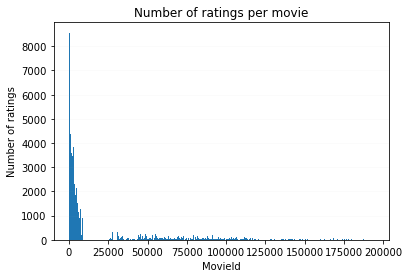

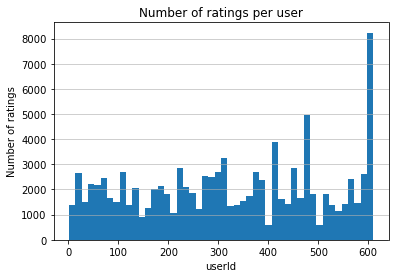

In [113]:
# a)
#first we will import the small data.
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


path = 'ml-latest-small' # 100K ratings
#path = 'ml-1m' # 1 million
df_ratings = pd.read_csv(path + '/ratings.csv')
print(df_ratings.head())
userId = df_ratings['userId']
movieId = df_ratings['movieId']
rating = df_ratings['rating']

userUnique = np.unique(userId)

#number of ratings per movie
hist = plt.hist(movieId, bins='auto')
plt.grid(axis='y', alpha=0.05)
plt.ylabel('Number of ratings')
plt.xlabel('MovieId')
plt.title('Number of ratings per movie')
plt.show()

#number of ratings per user
hist = plt.hist(userId, bins='auto')
plt.grid(axis='y', alpha=0.75)
plt.ylabel('Number of ratings')
plt.xlabel('userId')
plt.title('Number of ratings per user')
plt.show()


#let's find average ratings over all movies
avg = sum(rating)/len(rating)

#let's find the c value
userIdUnique, countRatings = np.unique(userId, return_counts=True) #counts of rating for each user
avgUsers = np.ones(len(userIdUnique)) #avg rating per user
c = np.ones(len(userIdUnique)) #c value

#first we will create a vector with avg rating per user
j = 0
for i in range(0,len(rating),countRatings[j]):
    temp = rating[i:i+countRatings[j]]
    avgUser = sum(temp)/len(temp)
    avgUsers[j] = avgUser
    j = j+1

#now we can find the c value

for i in range(len(avgUsers)):
    c[i] = "{:.2f}".format(avgUsers[i] - avg)
    

#let's find the d value
#since the matrix is sorted by user Id I need to find a way to sort it by movie Id
#for that I will create a dictionary

movieDict = {}
for i in range(len(movieId)):
    if movieId[i] in movieDict:
        movieDict[movieId[i]].append(rating[i])
    else:
        movieDict[movieId[i]] = [rating[i]]

#now we have all ratings for each movie, let's create movieRating
movieRating = {}
for i in range(max(movieId)):
    if i in movieDict:
        movieRating[i] = "{:.2f}".format(sum(movieDict[i])/len(movieDict[i]))


#now we can create d


b) [Matrix factorization model, 20 points] Use stochastic gradient descent to minimize
$$
\sum_{(u,i) \in Z}(r_{ui} - w_u^T h_i)^2 + \lambda (\sum_{u=1}^n ||w_u||^2 + \sum_{i=1}^m ||h_i||^2)
$$
with e.g. $k=20$. You can start with e.g. $\lambda=0.01$ and step-size $\alpha=0.05$ (some adjustments may be needed). To initialize the $w_u$ and $h_i$ vectors use normally distributed random values, e.g. with mean zero and standard deviation 0.02. You can perform the updates on the $w_u$ and $h_i$ vectors separately.

Monitor the root mean square error on both the training set and the test set. Keep track of the best set of parameter values ($w$ and $h$ vectors) and stop training when the test error starts to increase.

Report the root mean square error on the test set for the best parameters. How does this model compare to the one you found in a) in terms of RMSE?

*Comment*: You can generate normally distributed random variables with `np.random.randn`.

In [10]:
# Insert code here
# ...

c) [Matrix factorization model with bias, 10 points] Expand your model from b) by adding user-movie bias on the form
$$
b_{ui} = \mu + c_u + d_i.
$$
where $\mu$ is the global average of the ratings,
$$
\mu=\sum_{(u,i) \in Z} r_{ui} / |Z|
$$ (fixed throughout the iterations) but the vectors $c$ and $d$ are estimated along with the $w$ and $h$ vectors. The predictive model becomes
$$
\hat{r}_{ui} = \mu + c_u + d_i + w_u^T h_i
$$
and the least squares error criteria
$$
\sum_{(u,i) \in Z}(r_{ui} - \mu - c_u - d_i - w_u^T h_i)^2 + \lambda (\sum_{u=1}^n ||w_u||^2 + \sum_{i=1}^m ||h_i||^2 + ||c||^2 + ||d||^2)
$$
Test different values of $k$ and $\lambda$. Report the RMSE on the test set for the best model that you obtain. How does it compare to the models from a) and b)?

In [11]:
# Insert code here
# ...

d) [Model evaluation in the real world - open ended, 10 points] Use the best model from a) - c) to generate movie recommendations for a user that reflects your own taste in movies, or a user that has strong preference for particular genre(s) (e.g. a horror fan). Many recommender systems suffer ''popularity bias'', i.e. they tend to focus on popular items. Does your model have this tendency? Discuss briefly. Do you think that your model is useful in the real world?

Popularity bias in recomender systems and evaluation metrics are discussed in some detail here: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.465.96&rep=rep1&type=pdf

In [4]:
# Insert code here
# ...

The code below is for reading the MovieLens data. You can place it wherever you want in this workbook or hide it away in a function that you import.

In [5]:
# Read and preprocess the MovieLens data

import numpy as np
import pandas as pd

path = 'ml-latest-small' # 100K ratings
#path = 'ml-1m' # 1 million
df_ratings = pd.read_csv(path + '/ratings.csv')
print("Number of rows in original ratings matrix:", df_ratings.shape[0])

# Remove movies and users with few reviews
min_ratings = 10 # (feel free to change this value)
df_ratings = df_ratings.groupby('movieId').filter(lambda x : len(x) >= min_ratings)
print("Number of rows in ratings matrix after removing movies with few ratings:", df_ratings.shape[0])
df_ratings = df_ratings.groupby('userId').filter(lambda x : len(x) >= min_ratings)
print("Number of rows in ratings matrix after removing users with few reviews:", df_ratings.shape[0])
print("Number of users:", len(df_ratings['userId'].unique()))
print("Number of movies:", len(df_ratings['movieId'].unique()))

# THINK: Koren et al. used the timestamp to good effect
df_ratings.drop('timestamp', axis=1, inplace=True)
df_ratings.head()

Number of rows in original ratings matrix: 100836
Number of rows in ratings matrix after removing movies with few ratings: 81116
Number of rows in ratings matrix after removing users with few reviews: 81109
Number of users: 609
Number of movies: 2269


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
def convert_ids(values):
    # Convert Ids to consecutive integers
    newIds = {}
    count = 1
    for i in values:
        if i not in newIds:
            newIds[i] = count
            count += 1
    inv_Ids = dict(map(reversed, newIds.items()))
    return newIds, inv_Ids

# Read movie descriptions from file
df_movies = pd.read_csv(path + '/movies.csv')

print("Number of movies read from file:", df_movies.shape[0])
df_movies = df_movies[df_movies['movieId'].isin(df_ratings['movieId'].values)]
print("After filtering:", df_movies.shape[0])

# Make sure that userIds and movieIds are consecutive integers
userIds, inv_userIds = convert_ids(df_ratings['userId'].values)
df_ratings['userId'] = df_ratings['userId'].apply(lambda x: userIds[x])

movieIds, inv_movieIds = convert_ids(df_ratings['movieId'].values)
df_ratings['movieId'] = df_ratings['movieId'].apply(lambda x: movieIds[x])
df_movies['movieId'] = df_movies['movieId'].apply(lambda x: movieIds[x])

print("Number of users:", len(df_ratings['userId'].unique()))
print("Number of movies:", len(df_ratings['movieId'].unique()))

df_movies.head()

Number of movies read from file: 9742
After filtering: 2269
Number of users: 609
Number of movies: 2269


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,406,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
4,407,Father of the Bride Part II (1995),Comedy
5,3,Heat (1995),Action|Crime|Thriller


In [7]:
# Create random train/test split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_ratings, test_size=0.2, random_state=42) # 10% might be sufficient
ratings_train = df_train[['userId','movieId','rating']].values.astype(np.int32)
ratings_test = df_test[['userId','movieId','rating']].values.astype(np.int32)
print("Training set size: ", ratings_train.shape[0])
print("Test set size: ", ratings_test.shape[0])

Training set size:  64887
Test set size:  16222
